# LHC publications with HEPData records

This notebook counts all [INSPIRE](https://inspirehep.net) records that have an associated [HEPData](https://www.hepdata.net) record using the [INSPIRE API](https://github.com/inspirehep/rest-api-doc).

Count publications per LHC experiment per year and see which fraction has a HEPData record.

Written by Graeme Watt on 11th October 2017.  Updated for new INSPIRE API on 15th April 2021.

## Get results

Define a function to compose an Inspire query.

In [1]:
def compose_query(collaboration='', year=0, has_hepdata=False):
    """
    Compose an Inspire query for published papers, with optional arguments
    to restrict by collaboration, year, and presence of a HEPData record.
    """

    # Restrict search to papers published (in a refereed journal) that are not conference papers.
    query = 'tc p and not tc c'
    
    # Restrict to papers that appear in the hep-ex or nucl-ex primary arXiv categories.
    query += ' and (primarch hep-ex or primarch nucl-ex)'
    
    # Restrict search to a particular experimental collaboration.
    # Empty collaboration searches for papers from all four main LHC collaborations.
    if collaboration:
        query += ' and collaboration:{}'.format(collaboration)
    else:
        query += ' and (collaboration:ALICE or collaboration:ATLAS or ' + \
        'collaboration:CMS or collaboration:LHCb)'
        
    # Restrict search to a particular year.
    if year:
        query += ' and date {}'.format(year)
    
    # Restrict search to publications that have a corresponding HEPData record.
    if has_hepdata:
        query += ' and external_system_identifiers.schema:HEPData'
    
    return query

Define a function to get the number of Inspire records for a given query.

In [2]:
import requests

def get_num_results(query):
    """
    Make a search using the INSPIRE API (https://github.com/inspirehep/rest-api-doc)
    with output format in JSON and returning only the titles of the first record,
    to save unnecessary output.  Returns the number of records in the search result.
    """
    
    payload = {'q': query, 'size': 1, 'fields': 'titles'}
    url = 'https://inspirehep.net/api/literature'
    
    response = requests.get(url, params=payload)
    
    num_results = response.json()['hits']['total']
    
    return num_results

Produce results for all years, then 2010 up to 2023, and the four main LHC collaborations.

In [3]:
years = [0]
[years.append(year) for year in range(2010, 2024)]
collaborations = ['', 'ALICE', 'ATLAS', 'CMS', 'LHCb']

Loop over all years and collaborations and get number of results from Inspire.

In [4]:
num_results = {}
num_results_with_hepdata = {}
fraction_of_results_with_hepdata = {}

for year in years:

    num_results[year] = {} 
    num_results_with_hepdata[year] = {}
    fraction_of_results_with_hepdata[year] = {}
    
    for collaboration in collaborations:
        
        query = compose_query(collaboration, year)
        num_results[year][collaboration] = get_num_results(query)
        
        query_with_hepdata = compose_query(collaboration, year, True)
        num_results_with_hepdata[year][collaboration] = get_num_results(query_with_hepdata)
        
        if num_results[year][collaboration] > 0:
            fraction_of_results_with_hepdata[year][collaboration] = \
            float(num_results_with_hepdata[year][collaboration]) / \
            float(num_results[year][collaboration])
        else:
            fraction_of_results_with_hepdata[year][collaboration] = 0
        
        print('Year {}, {} collaboration, {} papers, {} with HEPData, fraction {:.2f}.'.format(
            year if year else 'all',collaboration if collaboration else 'ALICE+ATLAS+CMS+LHCb',
            num_results[year][collaboration],
            num_results_with_hepdata[year][collaboration],
            fraction_of_results_with_hepdata[year][collaboration]))

    print('')

Year all, ALICE+ATLAS+CMS+LHCb collaboration, 3497 papers, 1807 with HEPData, fraction 0.52.
Year all, ALICE collaboration, 434 papers, 405 with HEPData, fraction 0.93.
Year all, ATLAS collaboration, 1188 papers, 688 with HEPData, fraction 0.58.
Year all, CMS collaboration, 1190 papers, 633 with HEPData, fraction 0.53.
Year all, LHCb collaboration, 693 papers, 84 with HEPData, fraction 0.12.

Year 2010, ALICE+ATLAS+CMS+LHCb collaboration, 46 papers, 32 with HEPData, fraction 0.70.
Year 2010, ALICE collaboration, 11 papers, 10 with HEPData, fraction 0.91.
Year 2010, ATLAS collaboration, 14 papers, 10 with HEPData, fraction 0.71.
Year 2010, CMS collaboration, 19 papers, 10 with HEPData, fraction 0.53.
Year 2010, LHCb collaboration, 2 papers, 2 with HEPData, fraction 1.00.

Year 2011, ALICE+ATLAS+CMS+LHCb collaboration, 211 papers, 97 with HEPData, fraction 0.46.
Year 2011, ALICE collaboration, 14 papers, 13 with HEPData, fraction 0.93.
Year 2011, ATLAS collaboration, 92 papers, 47 with H

## Make some plots

In [5]:
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')
%matplotlib inline

Take all years together.  Make a bar chart of number of papers for {ALICE, ATLAS, CMS, LHCb} and the subset with a HEPData record.

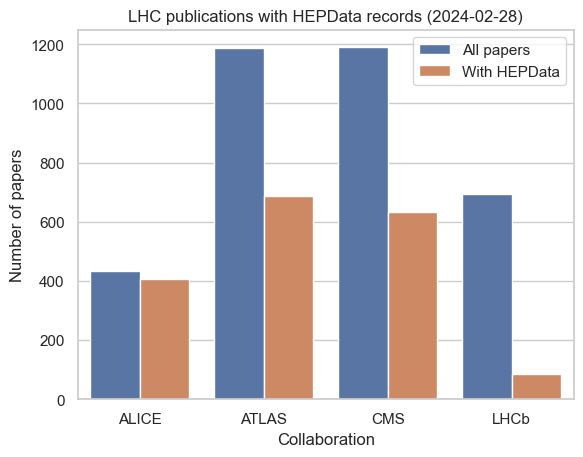

In [6]:
labels = [collaboration for collaboration in collaborations if collaboration]
values = [num_results[0][collaboration] for collaboration in collaborations if collaboration]
values_with_hepdata = [num_results_with_hepdata[0][collaboration] 
                       for collaboration in collaborations if collaboration]

plt.figure(facecolor='white')
x = 2*labels
y = values + values_with_hepdata
hue = len(labels)*['All papers'] + len(labels)*['With HEPData']
sns.barplot(x=x, y=y, hue=hue)
plt.title('LHC publications with HEPData records ({})'.format(date.today()))
plt.xlabel('Collaboration')
plt.ylabel('Number of papers')
plt.savefig('allyears_{}.png'.format(date.today()))
plt.show()

Plot the fraction of papers with a HEPData record for {ALICE, ATLAS, CMS, LHCb}.

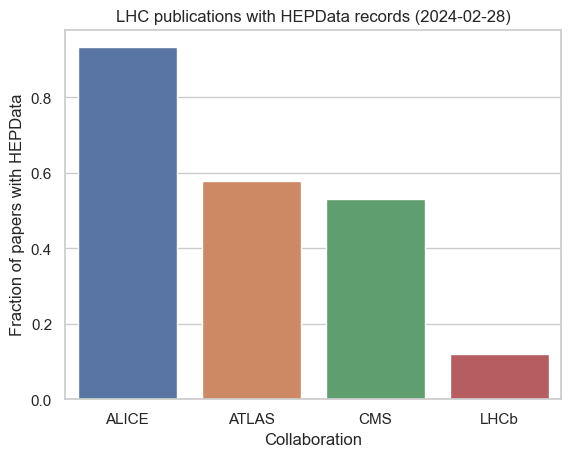

In [7]:
fraction_with_hepdata = [fraction_of_results_with_hepdata[0][collaboration]
                         for collaboration in collaborations if collaboration]
plt.figure(facecolor='white')
x = labels
y = fraction_with_hepdata
sns.barplot(x=x, y=y)
plt.title('LHC publications with HEPData records ({})'.format(date.today()))
plt.xlabel('Collaboration')
plt.ylabel('Fraction of papers with HEPData')
plt.savefig('allyears_fraction_{}.png'.format(date.today()))
plt.show()

For each of the four experiments {ALICE, ATLAS, CMS, LHCb}, make a bar chart of number of papers versus year.

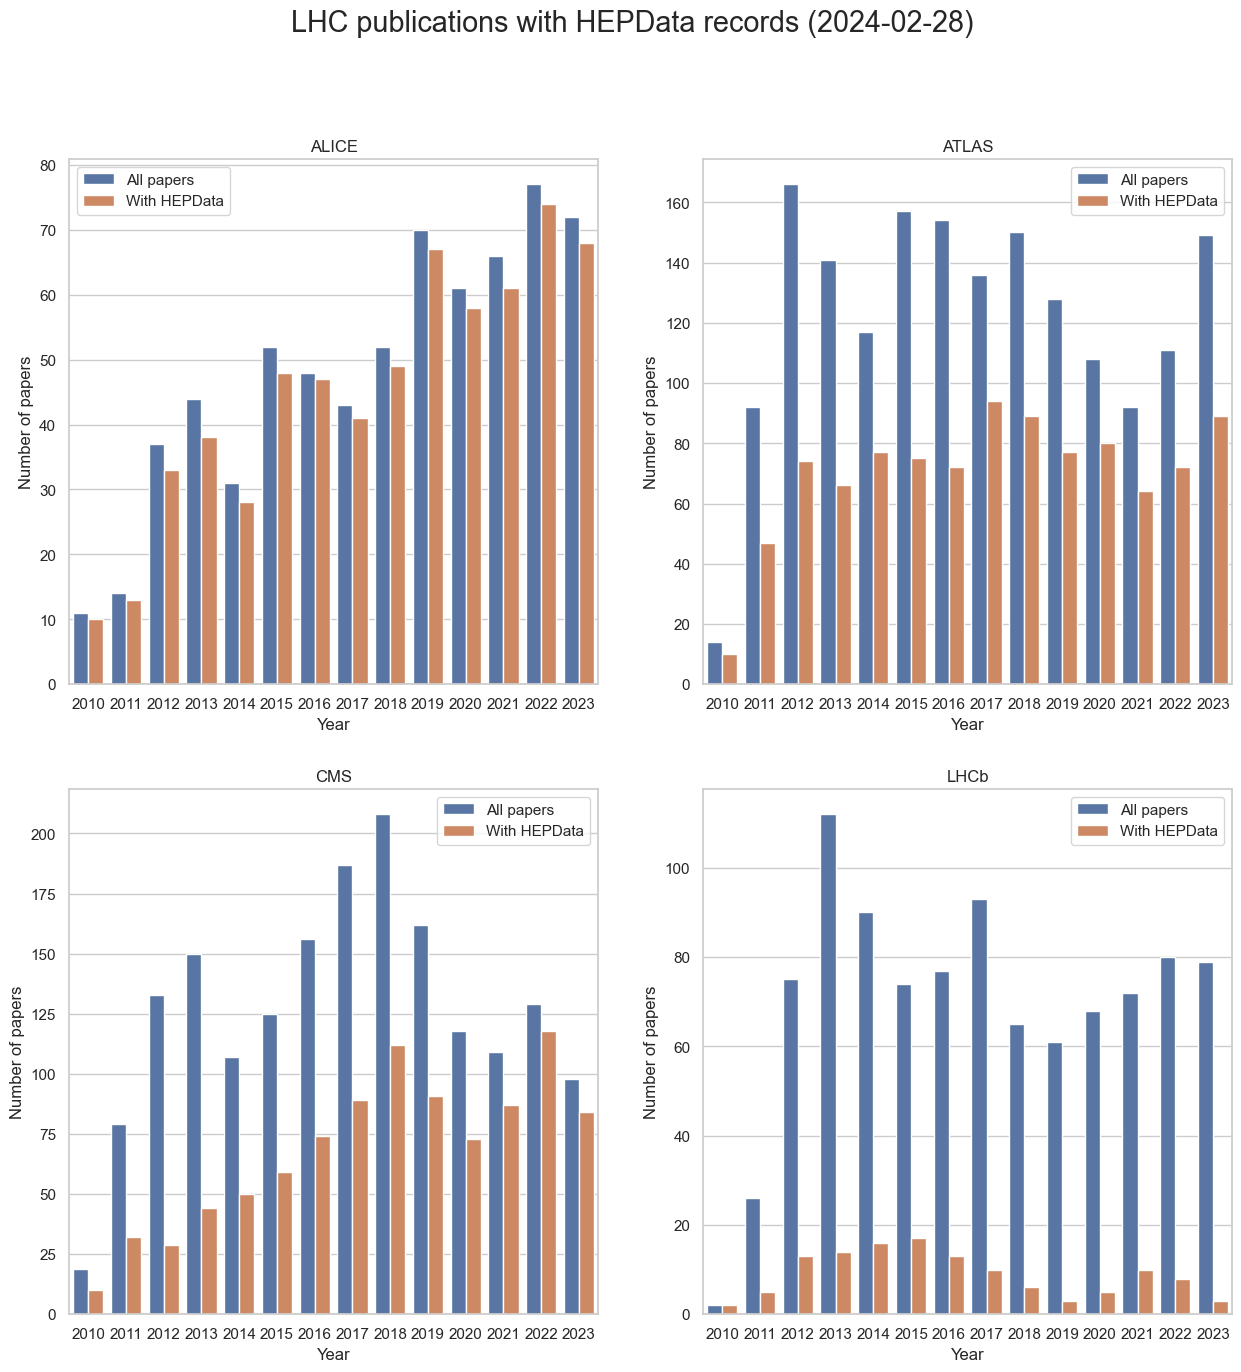

In [8]:
plt.figure(facecolor='white', figsize=(15,15))
for sub in range(1, 5):
    plt.subplot(2, 2, sub)
    collaboration = collaborations[sub]
    labels = [year for year in years if year]
    values = [num_results[year][collaboration] for year in years if year]
    values_with_hepdata = [num_results_with_hepdata[year][collaboration] 
                           for year in years if year]
    x = 2*labels
    y = values + values_with_hepdata
    hue = len(labels)*['All papers'] + len(labels)*['With HEPData']
    sns.barplot(x=x, y=y, hue=hue)
    plt.title(collaboration)
    plt.xlabel('Year')
    plt.ylabel('Number of papers')
plt.suptitle('LHC publications with HEPData records ({})'.format(date.today()), 
             fontsize='xx-large')
plt.savefig('breakdown_{}.png'.format(date.today()))
plt.show()

For each of the four experiments {ALICE, ATLAS, CMS, LHCb}, make a bar chart of the fraction of papers with a HEPData record versus year.

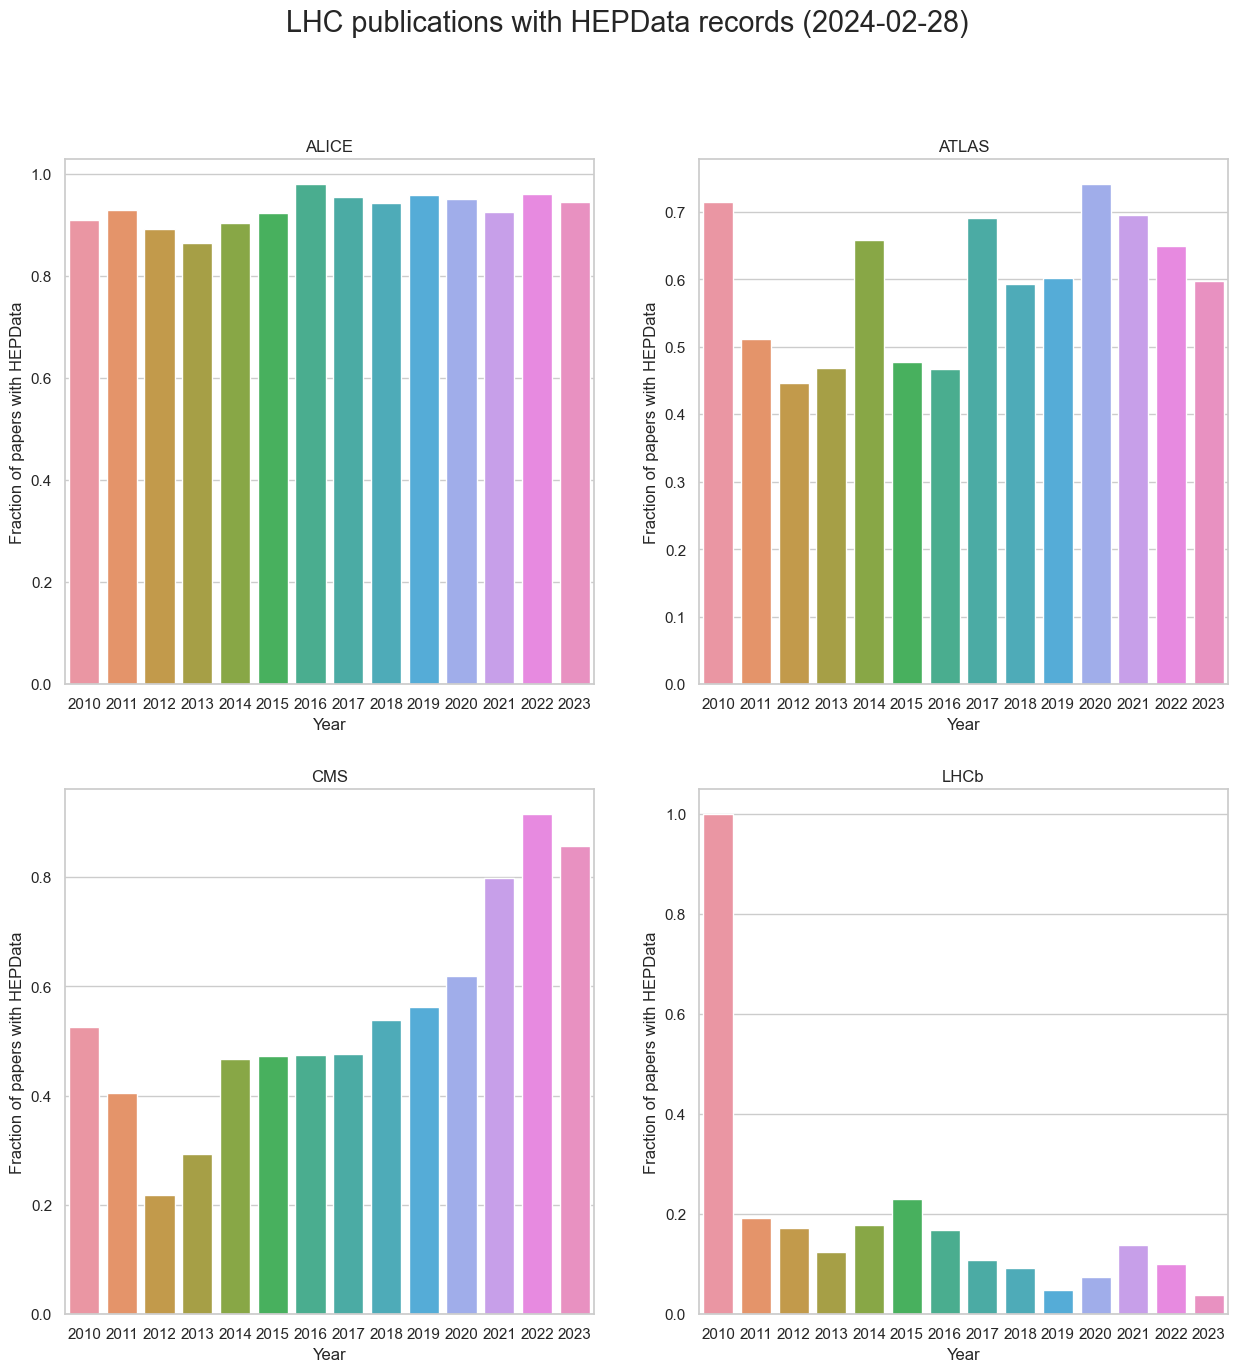

In [9]:
plt.figure(facecolor='white', figsize=(15,15))
for sub in range(1, 5):
    plt.subplot(2, 2, sub)
    collaboration = collaborations[sub]
    labels = [year for year in years if year]
    values = [num_results[year][collaboration] for year in years if year]
    fraction_with_hepdata = [fraction_of_results_with_hepdata[year][collaboration]
                             for year in years if year]
    x = labels
    y = fraction_with_hepdata
    sns.barplot(x=x, y=y)
    plt.title(collaboration)
    plt.xlabel('Year')
    plt.ylabel('Fraction of papers with HEPData')
plt.suptitle('LHC publications with HEPData records ({})'.format(date.today()), 
             fontsize='xx-large')
plt.savefig('breakdown_fraction_{}.png'.format(date.today()))
plt.show()

# Get results for your favourite experiment

In [10]:
my_collaboration = 'PHENIX'

query = compose_query(my_collaboration)
my_num_results = get_num_results(query)
        
query_with_hepdata = compose_query(my_collaboration, has_hepdata=True)
my_num_results_with_hepdata = get_num_results(query_with_hepdata)
        
if my_num_results > 0:
    my_fraction_of_results_with_hepdata = float(my_num_results_with_hepdata) / float(my_num_results)
else:
    my_fraction_of_results_with_hepdata = 0
        
print('{} collaboration, {} papers, {} with HEPData, fraction {:.2f}.'.format(
    my_collaboration, my_num_results, my_num_results_with_hepdata, my_fraction_of_results_with_hepdata))

PHENIX collaboration, 223 papers, 204 with HEPData, fraction 0.91.
